Hello! In this notebook we discuss the basics of quantum key distribution (QKD). Specifically, we look at BB84, the *one protocol that started it all*. Dun dun dunnn. 

We make use of Qiskit, which is IBM's open-source quantum computing software development framework. 

(Information about Qiskit and how to install it can be found in [1].)

## Introduction

Let's visit our old friends Alice and Bob, who want to share a secret message. Alice can send Bob a secret message by encrypting it with a one-time-key, which is an unbreakable encryption technique. A one-time key is just that: a key that is used once. By the time a third party -- let's call her Eve, shall we? -- gets her hands on the message, Alice and Bob would have discarded that key and moved on to another. So unless Eve has access to the key, or can accurately predict the key, she cannot decrypt the message.

'Key distribution' is essentially the process of getting the key to both communicating parties while minimizing the risk of Eve gaining knowledge of the key. In different words, a key distribution protocol’s purpose is to output a key at one end (Alice's), and a good estimate of that key at the other (Bob's).

When principles of quantum physics and qubit measurements come into the picture to create secure cryptographic keys, you've got quantum key distribution. 

Quantum key distribution is essentially made up of two parts. The first is the quantum component, in which quantum principles are used to check for the presence of an eavesdropper and a raw key is generated through qubit measurements.  The second is the classical part, in which the final key is distilled from the raw key through classical post-processing. We're going to stick to the quantum part and discuss the seminal BB84 protocol proposed by Bennett and Brassard in 1984 [2].


## How the BB84 Protocol Works

BB84 is a simple "prepare and measure" protocol in which Alice prepares a sequence of qubits,  sends the qubits to Bob, and then Bob measures them. The two discard those for which the measurement bases do not match. A subset of the remaining string of bits is used to check for the presence of sneaky Eve, and the rest is used as the raw key.

The protocol works something like this:

- Alice generates a random bit string.
- Alice encodes the bits in qubit states by randomly choosing between two bases, say, the perpendicular (z) and diagonal (x) bases. Let's say she uses photons as qubits. This scenario translates to a choice between rectilinear polarization and diagonal polarization.

She follows a convention that she established before hand, perhaps something like this:

|   | 0  | 1  |
|---|---|---|
|  z basis | $\uparrow$  | $\rightarrow$  |  
|  x basis | $\nwarrow$  | $\nearrow$  |   

Suppose Alice generates the bit string 100100. She then prepares a train of 6 photons in the following manner:


|  Alice's Random Bits |  1 | 0  | 0  | 1  | 0  | 0  |
|---|---|---|---|---|---|---|
| Alice's Random Basis Choice |  X | Z  |  Z |  X | Z  | X  |
| What Alice Sends Bob  |  $\nearrow$ |  $\uparrow$ | $\uparrow$  | $\nearrow$  | $\uparrow$  | $\nwarrow$  |


- Alice sends the qubit sequence to Bob over a quantum channel.
- Bob randomly chooses his measurement bases.
- Alice and Bob publicize their measurement bases choices through an open communication channel, and retain those qubits for which the bases match.


|  Alice's Random Bits |  1 | 0  | 0  | 1  | 0  | 0  |
|---|---|---|---|---|---|---|
| Alice's Random Basis Choice |  X | Z  |  Z |  X | Z  | X  |
|  What Alice Sends Bob |  $\nearrow$ |  $\uparrow$ | $\uparrow$  | $\nearrow$  | $\uparrow$  | $\nwarrow$  |
| Bob's Random Basis Choice  | X  | Z  |  X | X  | Z  | Z  |
| Shared Information  | 1  | 0  | -  | 1  | 0  |  -  |

- A subset of the sequence is used to check for the presence of an eavesdropper. So, if the first two bits are selected, then Alice and Bob would check if they both have the result 10. If their answers don't match, then Eve was probably snooping around. If their answers match, they can use the rest of the sequence, the second 10, as a raw key.

This is the end of the BB84 protocol, but Alice and Bob are not quite yet done with their work. They still have the classical component of QKD to work through! The key that they have at the end of the quantum part is a raw key. Usually the raw key is just that: raw with errors. A final key is distilled from the raw key through post-processing that is completely classical, because they are now working with bit strings. Post-processing includes  privacy amplification [3] and information reconcilliation [4]. 

Note that the final key needs to be at least as long as the message Alice wants to send in order for it to be used as a cryptographic key. Since the QKD process entails dropping parts of the sequence due to a basis mismatch, an eavesdrop check, and whatever is required during post-processing, the initial sequence should be much larger to account for any type of discardment [5]. 

Now let's put this into action using Qiskit, by looking at a very basic, ideal scenario. We will simplify what we've described by encoding 0's and 1's as $|0>$ and $|1>$ in the z-basis only (you can come back later to implement a convention like the one described above), and randomly choose between z and x measurements, that is, making use of the Z and H gates.

(If you are unfamiliar with quantum gates, or need a bit of a refresher, check out the Qiskit textbook [6].)


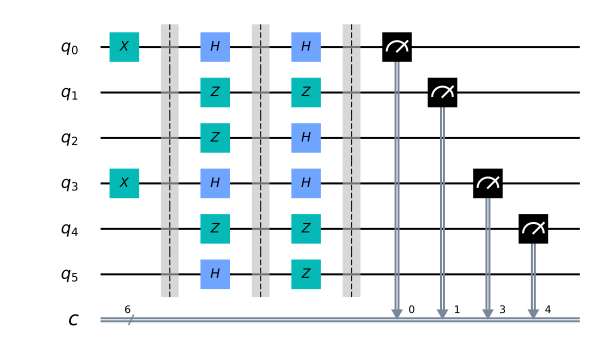

In [7]:
from qiskit import *
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg'

qc_ab = QuantumCircuit(6,6) #Create a quantum circuit with 6 qubits and 6 classical bits


##ENCODE BIT STRING
#The random bit sequence Alice needs to encode is: 100100, so the first and fourth qubits are flipped from |0> -> |1>
qc_ab.x(0) #The first qubit is indexed at 0, following Python being zero-indexed. From now on it'll be referred to as qubit 0 and so on.
qc_ab.x(3) 
qc_ab.barrier()


##ALICE CHOOSES
#Alice randomly chooses to apply an X or an H.  
#Note that since the state is already either a |0> or |1>, a Z essentially leaves the qubit state unchanged. But let's write it anyway, shall we? 

qc_ab.h(0) # or qc.z(0) # switch these based on your own choice
qc_ab.z(1) # or qc.h(1)
qc_ab.z(2) # or qc.h(2)
qc_ab.h(3) # or qc.z(3)
qc_ab.z(4) # or qc.h(4)
qc_ab.h(5) # or qc.z(5)
qc_ab.barrier()


##BOB CHOOSES
#Alice sends the qubit sequence to Bob, and Bob randomly chooses measurements
qc_ab.h(0) # or qc.z(0) # switch these based on your own choice
qc_ab.z(1) # or qc.h(1)
qc_ab.h(2) # or qc.z(2)
qc_ab.h(3) # or qc.z(3)
qc_ab.z(4) # or qc.h(4)
qc_ab.z(5) # or qc.h(5)
qc_ab.barrier()


##PUBLICIZE CHOICES
#Alice and Bob publicize their choices and only retain those for which their choices match. In this case: qubits 0,1,3,4. 
#Note: technically Bob performs the measurement BEFORE publicizing, but we're combining the two here since no one is actually communicating.

qc_ab.measure(0,0)
qc_ab.measure(1,1)
qc_ab.measure(3,3)
qc_ab.measure(4,4)


#qc_ab.measure(2,2) #come back to uncomment these to see what happens to the results after you've run this once
#qc_ab.measure(5,5)


qc_ab.draw(output='mpl') #let's see what this circuit looks like!





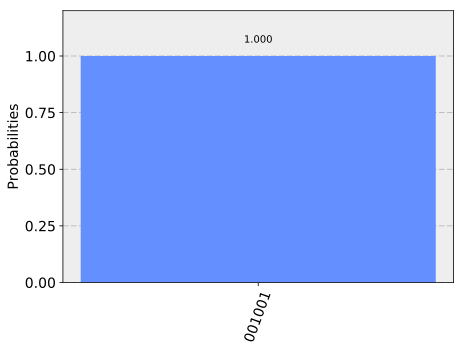

In [8]:
##EXECUTE
result = execute(qc_ab, Aer.get_backend('qasm_simulator')).result().get_counts() #We're only making use of the simulator. Refer to [2] to see how you can run this on a real quantum computer.
plot_histogram(result)

Notice that the only state with non-zero probability is the one corresponding to qubits 0,1,3,4 being 1,0,1,0. (The qubits read from right to left.)

If you uncommented the measurements for 2 and 5, you will still see states in which qubits 0,1,3,4 are 1,0,1,0, but now we have qubits 2 and 5 in the mix. They take all four possible combinations. This is because Alice and Bob chose different measurements for these two qubits! But the 1010 that they share remains the same.

If the first two are used as an eavesdropping check, Alice and Bob now share the raw key 10. Since this was run on the simulator, it shows the ideal scenario. In reality, noise and other factors could lead to a slight mismatch. This is where classical post-processing between the two comes in handy, to make sure Alice and Bob share the same key.

Now let's invite Eve to the party. We'll repeat what we did above, but with a sneaky extra set of measurements. Eve will intercept the quantum channel and make her own measurement choices, hoping she'll match with Alice and Bob. Since their communication is public, she can listen in to their measurement choices and see if her outcomes were correct.

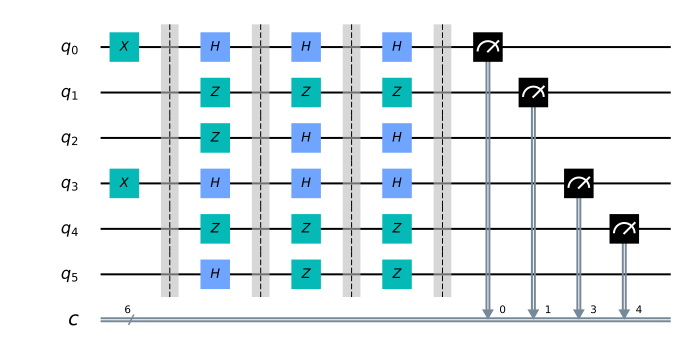

In [9]:
#Same situation but now with sneaky Eve 

qc_aeb = QuantumCircuit(6,6) #Create a quantum circuit with 6 qubits and 6 classical bits

##ENCODE BIT STRING
qc_aeb.x(0) 
qc_aeb.x(3) 
qc_aeb.barrier()

##ALICE CHOOSES
qc_aeb.h(0) 
qc_aeb.z(1) 
qc_aeb.z(2) 
qc_aeb.h(3) 
qc_aeb.z(4) 
qc_aeb.h(5) 
qc_aeb.barrier()

##EVE CHOOSES
qc_aeb.h(0) #play around with these to see how many states with non-zero probabilities show up at the end for a fixed set of Alice's and Bob's choices
qc_aeb.z(1) 
qc_aeb.h(2) 
qc_aeb.h(3) 
qc_aeb.z(4) 
qc_aeb.z(5) 
qc_aeb.barrier()

##BOB CHOOSES
qc_aeb.h(0) 
qc_aeb.z(1) 
qc_aeb.h(2) 
qc_aeb.h(3) 
qc_aeb.z(4) 
qc_aeb.z(5) 
qc_aeb.barrier()


##PUBLICIZE CHOICES

qc_aeb.measure(0,0)
qc_aeb.measure(1,1)
qc_aeb.measure(3,3)
qc_aeb.measure(4,4)

#qc_aeb.measure(2,2) #come back to uncomment these to see what happens to the results after you've run this once
#qc_aeb.measure(5,5)

qc_aeb.draw(output='mpl') #let's see what this circuit looks like!

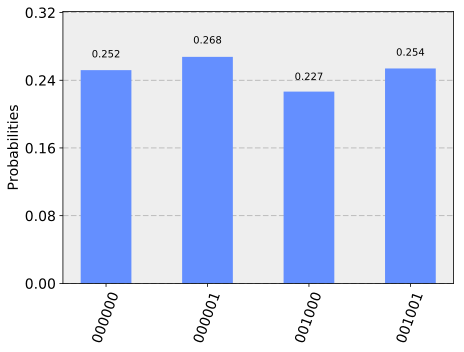

In [10]:
##EXECUTE
result = execute(qc_aeb, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(result)

You can see that out of four possibilities, only one involves Alice and Bob sharing the correct 1010. All the probabilities are pretty much comparable, which means Alice and Bob would very likely be able to detect the presence of Eve during their eavesdrop check! Now, try encoding the original bit sequence following a convention like the one described at the beginning for polarized photons. Note the differences from this simplified scenario.

(To see how to run this on a real quantum computer, check out [1, 6].)

[1] Coding with Qiskit: https://www.youtube.com/watch?v=M4EkW4VwhcI

[2] C.H. Bennett and G. Brassard. Quantum cryptography: public key distribution and coin tossing. Proc. IEEE Int. Conf. on Comp. Sys. Signal Process (ICCSSP), page 175, 1984.

[3] Privacy amplification involves methods to have two parties share secret information over public channels or channels controlled by a computationally unbound eavesdropper.

[4] Information reconciliation involves making sure the two parties share the same information.

[5] Discardment also occurs due to some qubits failing to register when they're sent to Bob over the quantum channel.

[6] Qiskit Textbook: https://qiskit.org/textbook/ch-gates/introduction.html

[7] Michael A. Nielsen and Isaac L. Chuang. Quantum Computation and Quantum Information:
10th Anniversary Edition. 10th. New York, NY, USA: Cambridge University
Press, 2011. ISBN: 1107002176, 9781107002173.
